# Earnings Call Project: Data Cleaning
<br>
CIS 831 Deep Learning – Term Project<br>
Kansas State University
<br><br>
James Chapman<br>
John Woods<br>
Nathan Diehl<br>
<br>

This notebook sums up to one big sanity check. We get somewhat close results to the published paper. It gives us confidence in the data preparation.

These notebooks also give us a playground to work with the data, and test the models. Now we can insert sentiment detection, segmentation of the text, etc.

In [3]:
import pandas as pd
import numpy as np
import time
import math
import os
from datetime import datetime
from tqdm import tqdm
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils import data
from torch.optim.lr_scheduler import LambdaLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# This is the hierarchical transformer from the HTML paper.

## This is taken directly from the GitHub account for HTML paper.
- a few adaptions are highlighted with ##############################################


- [GitHub HTML - util.py](https://github.com/YangLinyi/HTML-Hierarchical-Transformer-based-Multi-task-Learning-for-Volatility-Prediction/blob/master/Model/Sentence-Level-Transformer/transformers/util/util.py)
- [GitHub HTML - transformers_gpu.py](https://github.com/YangLinyi/HTML-Hierarchical-Transformer-based-Multi-task-Learning-for-Volatility-Prediction/blob/master/Model/Sentence-Level-Transformer/transformers/transformers_gpu.py)

In [5]:

# https://github.com/YangLinyi/HTML-Hierarchical-Transformer-based-Multi-task-Learning-for-Volatility-Prediction/blob/master/Model/Sentence-Level-Transformer/transformers/transformers_gpu.py
def mask_(matrices, maskval=0.0, mask_diagonal=True):
    """
    Masks out all values in the given batch of matrices where i <= j holds,
    i < j if mask_diagonal is false

    In place operation

    :param tns:
    :return:
    """

    b, h, w = matrices.size()

    indices = torch.triu_indices(h, w, offset=0 if mask_diagonal else 1)
    matrices[:, indices, indices[1]] = maskval

def contains_nan(tensor):
    return bool((tensor != tensor).sum() > 0)

# https://github.com/YangLinyi/HTML-Hierarchical-Transformer-based-Multi-task-Learning-for-Volatility-Prediction/blob/master/Model/Sentence-Level-Transformer/transformers/transformers_gpu.py
class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):
        """
        :param emb:
        :param heads:
        :param mask:
        """

        super().__init__()

        self.emb = emb
        self.heads = heads
        self.mask = mask

        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # compute scaled dot-product self-attention

        # - fold heads into the batch dimension
        keys = keys.transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values = values.transpose(1, 2).contiguous().view(b * h, t, e)

        queries = queries / (e ** (1/4))
        keys    = keys / (e ** (1/4))
        # - Instead of dividing the dot products by sqrt(e), we scale the keys and values.
        #   This should be more memory efficient

        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2))

        assert dot.size() == (b*h, t, t)

        if self.mask: # mask out the lower half of the dot matrix,including the diagonal
            mask_(dot, maskval=float('-inf'), mask_diagonal=False)

        dot = F.softmax(dot, dim=2) # dot now has row-wise self-attention probabilities

        ##############################################
        ##############################################
        # assert not util.contains_nan(dot[:, 1:, :]) # only the forst row may contain nan
        assert not contains_nan(dot[:, 1:, :]) # only the forst row may contain nan 
        ##############################################
        ##############################################
        
        if self.mask == 'first':
            dot = dot.clone()
            dot[:, :1, :] = 0.0
            # - The first row of the first attention matrix is entirely masked out, so the softmax operation results
            #   in a division by zero. We set this row to zero by hand to get rid of the NaNs

        # apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, e)

        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)

class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads, mask=mask)
        self.mask = mask

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x
##RTransformer

class RTransformer(nn.Module):
    """
    Transformer for sequences Regression    
    
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        emb: Embedding dimension
        heads: nr. of attention heads
        depth: Number of transformer blocks
        seq_length: Expected maximum sequence length
        num_tokens: Number of tokens (usually words) in the vocabulary
        num_classes: Number of classes.
        max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        #self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)
        self.toprobs_b = nn.Linear(emb, num_classes)
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        sentences_emb = x
        b, t, e = x.size()

        ##############################################
        ##############################################
        # swap d() for device
        # positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        ##############################################
        ##############################################
        #positions = self.pos_embedding(torch.arange(t))[None, :, :].expand(b, t, e)
        #positions = torch.tensor(positions, dtype=torch.float32)
        x = sentences_emb.cuda() + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension
        
        
        x_a = self.toprobs(x)
        x_b = self.toprobs_b(x)
        x_a = torch.squeeze(x_a)
        x_b = torch.squeeze(x_b)
        #print('x shape: ',x.shape)
        return x_a, x_b

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):

        super().__init__()

        self.num_tokens, self.max_pool = num_tokens, max_pool

        self.token_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=num_tokens)
        self.pos_embedding = nn.Embedding(embedding_dim=emb, num_embeddings=seq_length)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, mask=False, dropout=dropout, wide=wide))

        self.tblocks = nn.Sequential(*tblocks)

        self.toprobs = nn.Linear(emb, num_classes)

        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()

        ##############################################
        ##############################################
        # swap d() for device
        # positions = self.pos_embedding(torch.arange(t, device=d()))[None, :, :].expand(b, t, e)
        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        ##############################################
        ##############################################
        x = tokens + positions
        x = self.do(x)

        x = self.tblocks(x)

        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1) # pool over the time dimension

        x = self.toprobs(x)

        return F.log_softmax(x, dim=1)

# This is the dataset builder and training loop. Hyperparameters were given in the paper, so we do not do any validation or hyperparameter tuning.

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, labels, labels_b):
        self.embeddings = embeddings
        self.labels = labels
        self.labels_b = labels_b

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        label = self.labels[idx]
        label_b = self.labels_b[idx]
        return emb, label, label_b
        
TEXT_emb = np.load('data/TEXT_emb.npy')
LABEL_emb = np.load('data/LABEL_emb.npy')
LABEL_emb_b = np.load('data/LABEL_emb_b.npy')

print(TEXT_emb.shape, LABEL_emb.shape, LABEL_emb_b.shape) 

data_train, test, label_train, test_label, label_train_b, test_label_b = train_test_split(
    TEXT_emb, LABEL_emb, LABEL_emb_b, test_size=0.2, random_state=42
)
train, val, train_label, val_label, train_label_b, val_label_b = train_test_split(
    data_train, label_train, label_train_b, test_size=0.125, random_state=42
)
# Hyper-parameters were given in the paper.
# Therefore we do not need a validation set
training_set = Dataset(data_train, label_train, label_train_b) #train, train_label, train_label_b) # if needing validation set
val_set = Dataset(val, val_label, val_label_b)
test_set = Dataset(test, test_label, test_label_b)

trainloader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True, num_workers=0)

print(train.shape, train_label.shape, train_label_b.shape) 
print(val.shape, val_label.shape, val_label_b.shape) 
print(test.shape, test_label.shape, test_label_b.shape) 


(565, 523, 1051) (565,) (565,)
(395, 523, 1051) (395,) (395,)
(57, 523, 1051) (57,) (57,)
(113, 523, 1051) (113,) (113,)


In [8]:
model = RTransformer(emb=1051, heads=2, depth=2, seq_length=523, num_tokens=4000, 
                     num_classes=1, max_pool=False, dropout=0).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.00002)
# Linear LR warmup for the first 1000 steps
scheduler = LambdaLR(opt, lr_lambda=lambda step: min(1.0, step / 1000))

seen = 0
evaluation = {'epoch': [], 'Train Loss': [], 'Test Loss A': [], 'Test Loss B': []}
progress_bar = tqdm(range(10), desc="Training Progress", unit="epoch")
for epoch in progress_bar:
    model.train()
    train_loss_total = 0.0
    
    for i, (inputs, labels, labels_b) in enumerate(trainloader): #training data
        seen += inputs.size(0)
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        labels_b = labels_b.to(device, dtype=torch.float32)

        out_a, out_b = model(inputs)

        # Compute the combined loss
        loss_a = F.mse_loss(out_a, labels)
        loss_b = F.mse_loss(out_b, labels_b)
        loss = 0.5 * loss_a + 0.5 * loss_b # Alpha parameter?
        
        train_loss_total += loss_a.item() # MSE of volatility

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if seen < 1000:
            scheduler.step()


    # Epoch average
    train_loss_avg = train_loss_total / (i + 1)
    
    # Epoch Evaluation
    model.eval()
    test_loss_a_total = 0.0
    test_loss_b_total = 0.0
    with torch.no_grad():
        for i, (inputs, labels, labels_b) in enumerate(testloader):
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.float32)
            labels_b = labels_b.to(device, dtype=torch.float32)

            out_a, out_b = model(inputs)

            loss_a = F.mse_loss(out_a, labels)
            loss_b = F.mse_loss(out_b, labels_b)

            test_loss_a_total += loss_a.item()
            test_loss_b_total += loss_b.item()

        # Average test losses
        test_loss_a_avg = test_loss_a_total / (i + 1)
        test_loss_b_avg = test_loss_b_total / (i + 1)

    # Epoch finished
    evaluation['epoch'].append(epoch+1)
    evaluation['Train Loss'].append(train_loss_avg)
    evaluation['Test Loss A'].append(test_loss_a_avg)
    evaluation['Test Loss B'].append(test_loss_b_avg)

    # Update progress bar description and postfix
    progress_bar.set_description(f"Epoch {epoch+1}/{10}")
    progress_bar.set_postfix({
        "Train Loss": f"{train_loss_avg:.4f}",
        "Test Loss A": f"{test_loss_a_avg:.4f}",
        "Test Loss B": f"{test_loss_b_avg:.4f}"
    })

Epoch 10/10: 100%|██████████| 10/10 [00:33<00:00,  3.39s/epoch, Train Loss=1.4504, Test Loss A=1.2404, Test Loss B=7.1345]


In [9]:
evaluation

{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Train Loss': [10.588692032526025,
  1.4240660680606303,
  1.4643933522490273,
  1.4703845788881313,
  1.4112557980800624,
  1.4154809369516057,
  1.467929404690466,
  1.4367241924381362,
  1.434891857470559,
  1.4504406264925425],
 'Test Loss A': [1.232411503791809,
  1.2263922691345215,
  1.2949713468551636,
  1.2003692388534546,
  1.1965383291244507,
  1.3838891983032227,
  1.175402045249939,
  1.1894415616989136,
  1.1770046949386597,
  1.2404026985168457],
 'Test Loss B': [7.303164958953857,
  7.105856895446777,
  7.247414588928223,
  7.834558486938477,
  7.604280471801758,
  7.709494113922119,
  7.142139434814453,
  7.200875282287598,
  7.3133134841918945,
  7.134471416473389]}


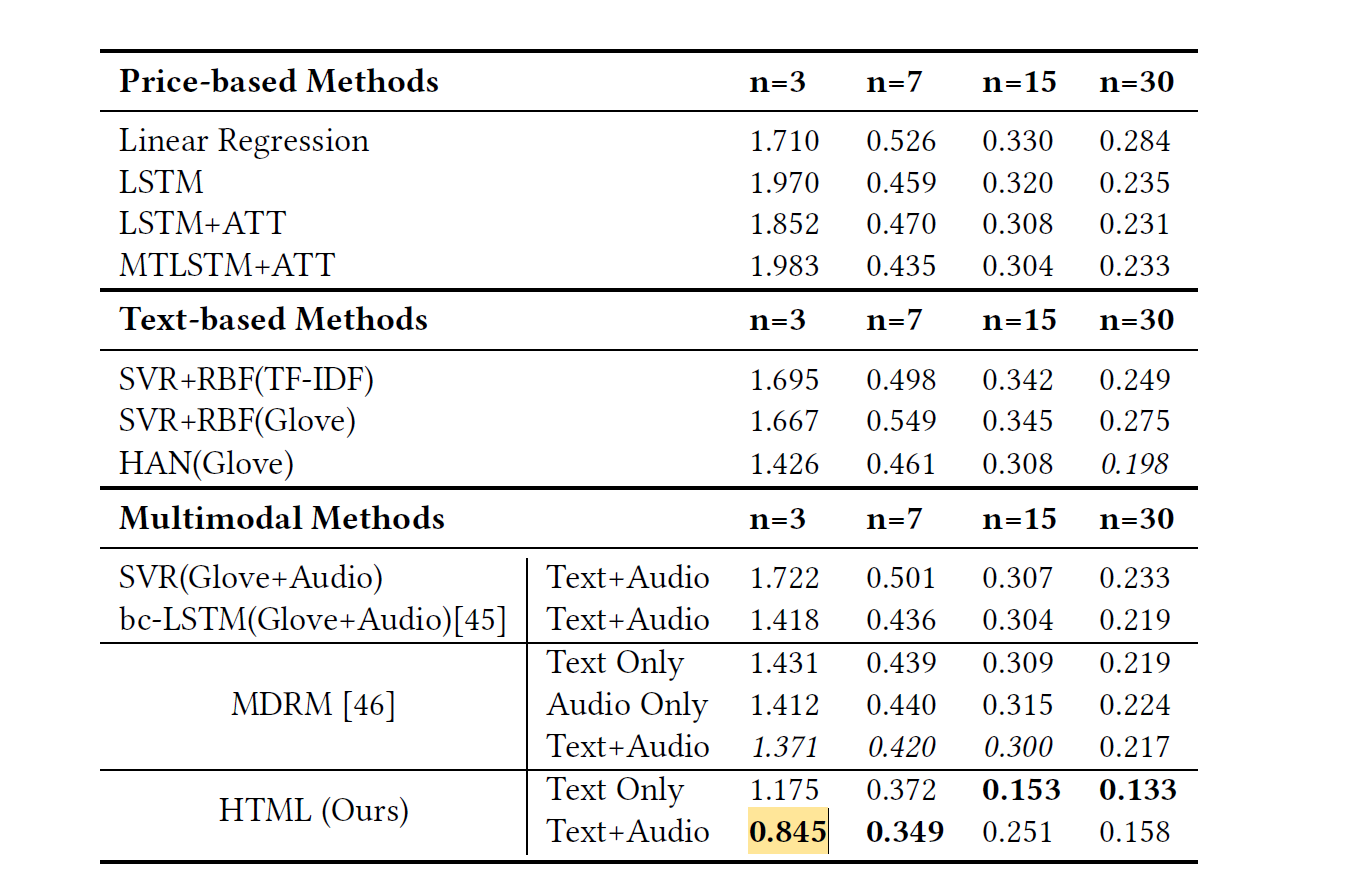

In [16]:
display(HTML(img_tag))

In [10]:
:)

SyntaxError: unmatched ')' (1896645534.py, line 1)